# Algotytm przecinania się odcinków na płaszczyźnie

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer
from functools import reduce
%pip install sortedcontainers
from sortedcontainers import SortedSet

Note: you may need to restart the kernel to use updated packages.


# Przydatne funkcje 

In [223]:
np.random.seed(100)

eps = 10**(-12)
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def lines(self, line_1, line_2):
        self.line_1 = line_1
        self.line_2 = line_2

    def __eq__(self, point):
        return self.x == point.x and self.y == point.y

    def __le__(self, point):
        return self.x <= point.x

    def __hash__(self):
        return self.x.__hash__() * self.y.__hash__()

    def to_tuple(self):
        return self.x, self.y
    
def convert_to_point_lines(lines):
    nl = [None for _ in range(len(lines))]
    for idx, line in enumerate(lines):
        point_1 = Point(line[0][0], line[0][1])
        point_2 = Point(line[1][0], line[1][1])
        nl[idx] = Line(point_1, point_2)
    return nl

class Line:
    def __init__(self, point_1, point_2):
        if point_1.x < point_2.x:
            self.point_1 = point_1
            self.point_2 = point_2
        else:
            self.point_1 = point_2
            self.point_2 = point_1

    def get_y(self, x):
        a = (self.point_2.y - self.point_1.y) / (self.point_2.x - self.point_1.x)
        b = self.point_2.y - a * self.point_2.x
        return a * x + b

    def to_tuple(self):
        return self.point_1.to_tuple(), self.point_2.to_tuple()
    

def draw_example_1():
    # TODO narysowac to uzywając naszego narzędzia do wizualizacji
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    # TODO narysowac to uzywając naszego narzędzia do wizualizacji
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()

def draw_segments(lines):
    vis = Visualizer()
    vis.add_line_segment(lines)
    vis.show()

def draw_save_segments(lines, filename):
    vis = Visualizer()
    vis.add_line_segment(lines)
    vis.show()
    vis.save(filename)


def draw_intersecitons(segments, intersections):
    vis = Visualizer()
    points = [i[0] for i in intersections]
    vis.add_line_segment(segments)
    vis.add_point(points, color="red")
    vis.show()

def draw_save_intersecitons(segments, intersections, filename):
    vis = Visualizer()
    points = [i[0] for i in intersections]
    vis.add_line_segment(segments)
    vis.add_point(points, color="red")
    vis.save(filename)
    vis.show()


def orientation(a, b, c):
    val = (b[1] - a[1]) * (c[0] - b[0]) - (b[0] - a[0]) * (c[1] - b[1])
    if val == 0:
        return 0
    return 1 if val > 0 else 2

def find_intersection(line1, line2):
    x1, y1 = line1[0]
    x2, y2 = line1[1]
    x3, y3 = line2[0]
    x4, y4 = line2[1]
    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if det == 0: return 0
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / det
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / det

    if 0 <= t <= 1 and 0 <= u <= 1:
        intersection_x = x1 + t * (x2 - x1)
        intersection_y = y1 + t * (y2 - y1)
        return (intersection_x, intersection_y)
    else:
        return None
    
def add_line(line, sorted_lines, events, intersections):
    sorted_lines.add(line)
    index = sorted_lines.index(line)

    if index - 1 >= 0 and index + 1 < len(sorted_lines):
        intersection = lines_intersection(sorted_lines[index - 1], sorted_lines[index + 1])
        if intersection is not None and intersection in events:
            events.remove(intersection)

    if index - 1 >= 0:
        intersection = lines_intersection(sorted_lines[index - 1], line)
        if intersection and intersection not in events and intersection not in intersections:
            events.add(intersection)
            
    if index + 1 < len(sorted_lines):
        intersection = lines_intersection(line, sorted_lines[index + 1])
        if intersection and intersection not in events and intersection not in intersections:
            events.add(intersection)

def remove_line(line, sorted_lines, events, intersections):
    index = sorted_lines.index(line)

    if index - 1 >= 0 and index + 1 < len(sorted_lines):
        intersection = lines_intersection(sorted_lines[index - 1], sorted_lines[index + 1])
        if intersection is not None and intersection not in intersections:
            events.add(intersection)
    sorted_lines.remove(line)
    
def coords(l1, l2):
    b1, b2 = 0, 0
    a1, a2 = 0,0
    (x1,y1), (x2, y2) = l1
    (x3,y3), (x4, y4) = l2
    a1 = (y2- y1)/(x2-x1)
    a2 = (y4- y3)/(x4-x3)
    b1 = y1 - x1 * a1
    b2 = y3 - x3 * a2
    x_coord = (b2 - b1) / (a1 - a2)
    y_coord = a1 * x_coord + b1

    return x_coord, y_coord

def seg_orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0  # Collinear points
    return 1 if val > 0 else 2  # Clockwise or counterclockwise

def intersect(segment1, segment2):
    p1, q1 = segment1
    p2, q2 = segment2

    o1 = seg_orientation(p1, q1, p2)
    o2 = seg_orientation(p1, q1, q2)
    o3 = seg_orientation(p2, q2, p1)
    o4 = seg_orientation(p2, q2, q1)

    # General case
    if o1 != o2 and o3 != o4:
        return True
    
def lines_intersection(line_1, line_2):
    orientation_11 = orientation(line_1.point_1.to_tuple(), line_1.point_2.to_tuple(), line_2.point_1.to_tuple())
    orientation_12 = orientation(line_1.point_1.to_tuple(), line_1.point_2.to_tuple(), line_2.point_2.to_tuple())
    orientation_21 = orientation(line_2.point_1.to_tuple(), line_2.point_2.to_tuple(), line_1.point_1.to_tuple())
    orientation_22 = orientation(line_2.point_1.to_tuple(), line_2.point_2.to_tuple(), line_1.point_2.to_tuple())

    if orientation_11 != orientation_12 and orientation_21 != orientation_22:
        a_1 = (line_1.point_2.y - line_1.point_1.y) / (line_1.point_2.x - line_1.point_1.x)
        b_1 = line_1.point_1.y - a_1 * line_1.point_1.x

        a_2 = (line_2.point_2.y - line_2.point_1.y) / (line_2.point_2.x - line_2.point_1.x)
        b_2 = line_2.point_1.y - a_2 * line_2.point_1.x

        x = (b_2 - b_1) / (a_1 - a_2)
        y = a_1 * (b_2 - b_1) / (a_1 - a_2) + b_1

        point = Point(x, y)
        point.lines(line_1, line_2)
        return point
    return None

In [74]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    res = []
    for _ in range(n):
        x1 = np.random.uniform(0, max_x)
        x2 = np.random.uniform(0, max_x)
        y1 = np.random.uniform(0, max_y)
        y2 = np.random.uniform(0, max_y)
        if x1 > x2: x1, x2 = x2, x1
        res.append(((x1, y1), (x2, y2)))
    return res

In [75]:
test = [((1.1705069124423964, 8.566820276497698),
  (7.400921658986174, 7.497695852534564)),
 ((3.6221198156682033, 5.23041474654378),
  (5.59447004608295, 2.2995391705069137)),
 ((4.304147465437788, 6.870967741935486),
  (8.433179723502304, 6.059907834101384)),
 ((2.552995391705069, 0.4562211981566826),
  (8.857142857142858, 2.539170506912443))]
a = [((0.6728110599078341, 9.027649769585256),
  (9.11520737327189, 0.548387096774194)),
 ((0.6543778801843319, 5.580645161290324),
  (3.3456221198156686, 7.958525345622123)),
 ((1.4654377880184333, 4.198156682027651),
  (5.078341013824884, 6.686635944700463)),
 ((2.3317972350230414, 2.5576036866359457),
  (8.96774193548387, 8.364055299539173)),
 ((1.576036866359447, 8.935483870967744),
  (7.3271889400921655, 3.9953917050691254)),
 ((0.41474654377880205, 7.921658986175117),
  (3.456221198156682, 1.8202764976958534)),
 ((4.451612903225806, 9.414746543778804),
  (4.488479262672811, 0.32718894009216637)),
 ((0.5622119815668203, 0.8433179723502311),
  (9.152073732718893, 1.87557603686636)),
 ((5.889400921658986, 8.880184331797237),
  (7.953917050691244, 6.428571428571431))]
b = [((0.9308755760368665, 7.479262672811062),
  (9.059907834101383, 7.682027649769587)),
 ((0.7649769585253456, 5.451612903225808),
  (9.705069124423963, 6.539170506912444)),
 ((1.1705069124423964, 4.179723502304149),
  (9.44700460829493, 4.99078341013825)),
 ((0.967741935483871, 2.66820276497696),
  (8.857142857142858, 3.055299539170508)),
 ((1.0414746543778803, 1.4884792626728116),
  (9.188940092165899, 1.8202764976958534))]
c = [((2.2396313364055302, 8.677419354838712),
  (8.4147465437788, 2.281105990783411)),
 ((1.0230414746543781, 7.110599078341016),
  (6.516129032258064, 7.331797235023043)),
 ((1.3732718894009217, 6.078341013824886),
  (7.695852534562212, 6.2442396313364075)),
 ((2.055299539170507, 5.046082949308757),
  (8.617511520737327, 5.654377880184334)),
 ((0.9861751152073732, 4.10599078341014),
  (9.078341013824884, 4.235023041474656)),
 ((0.9308755760368665, 3.239631336405531),
  (8.87557603686636, 3.4792626728110614)),
 ((0.967741935483871, 8.271889400921662),
  (5.1336405529953915, 2.410138248847927))]
d= [((2.110599078341014, 9.193548387096776),
  (2.7557603686635948, 8.769585253456224)),
 ((1.7235023041474657, 7.8479262672811085),
  (5.2073732718894, 8.51152073732719)),
 ((2.4976958525345627, 6.797235023041477),
  (5.2073732718894, 6.152073732718896)),
 ((7.622119815668203, 8.364055299539173),
  (8.4147465437788, 5.709677419354841)),
 ((4.5437788018433185, 3.6082949308755774),
  (9.188940092165899, 7.055299539170509)),
 ((1.6313364055299542, 5.635944700460831),
  (7.751152073732719, 3.2764976958525356)),
 ((1.096774193548387, 1.617511520737328),
  (9.170506912442397, 2.1336405529953923)),
 ((1.7603686635944702, 3.0184331797235036),
  (6.184331797235023, 5.8571428571428585)),
 ((3.824884792626728, 9.322580645161292),
  (7.953917050691244, 4.456221198156683)),
 ((0.8940092165898617, 6.944700460829495),
  (9.2073732718894, 7.884792626728112)),
 ((1.2073732718894008, 3.958525345622121),
  (1.8341013824884795, 0.8617511520737333)),
 ((0.5069124423963136, 2.4285714285714297),
  (7.013824884792626, 9.156682027649772)),
 ((4.875576036866359, 2.8341013824884804),
  (6.792626728110598, 2.870967741935485)),
 ((3.769585253456221, 2.2626728110599084),
  (4.396313364055299, 0.8801843317972355)),
 ((7.824884792626728, 1.1198156682027658),
  (9.023041474654377, 3.3502304147465454)),
 ((2.5161290322580645, 2.3179723502304155),
  (3.19815668202765, 1.1566820276497702)),
 ((6.0921658986175125, 0.91705069124424),
  (7.253456221198157, 1.3594470046082956)),
 ((9.2073732718894, 5.359447004608296),
  (9.834101382488479, 4.032258064516131)),
 ((8.027649769585253, 9.322580645161292),
  (9.262672811059907, 8.585253456221201)),
 ((0.8571428571428572, 9.285714285714288),
  (3.382488479262673, 8.99078341013825))]
e = [((3.5483870967741935, 8.253456221198158),
  (9.2073732718894, 2.6313364055299546)),
 ((1.6129032258064515, 5.396313364055301),
  (8.525345622119815, 8.695852534562214)),
 ((1.4101382488479262, 7.018433179723504),
  (9.170506912442397, 6.539170506912444)),
 ((0.7834101382488479, 3.903225806451614),
  (6.64516129032258, 9.009216589861753))]
f = generate_uniform_sections(100, 100 ,30)
test_examples = [b, e, c, a, d, f]

### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [5]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.115s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [6]:
section = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

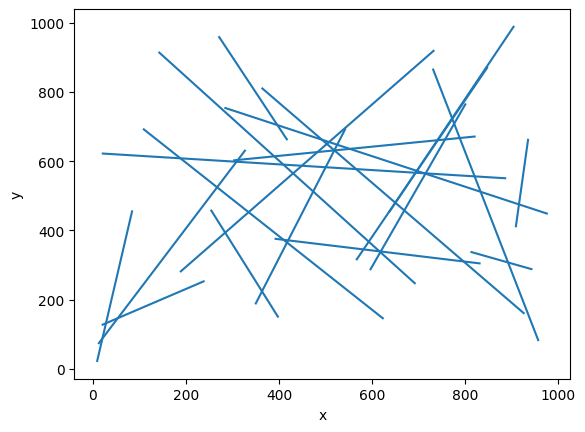

In [7]:
draw_segments(section)

Uzupełnij funkcję ```add_sections``` #interaktywne dodawanie odcinków przez rysowanie myszką (jak?) TODO

In [8]:
def add_sections(n):
    '''
Żeby skorzystać z graficznego wprowadzania odcinków należy wywołać funkcję `draw_app` z argumentem, 
który oznacza liczbę prostych. Wynik można zapisać do zmiennej,
np: `sections = draw_app(10)`.
'''
    %matplotlib tk
    clicks = []

    def onclick(event):
        x = event.xdata
        y = event.ydata
        if x is not None and y is not None:
            clicks.append((x, y))

    res = []
    fig, ax = plt.subplots(figsize = (7,7))
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    while len(clicks) == 0:
        plt.pause(0.1)
    while len(clicks) == 1:
        plt.pause(0.1)
        plt.scatter(clicks[-1][0], clicks[-1][1], marker='o', color="red")
    
    plt.scatter(clicks[-1][0], clicks[-1][1], marker='o', color="red")
    plt.plot((clicks[-1][0], clicks[-2][0]), (clicks[-1][1], clicks[-2][1]),color="blue")

    while len(clicks) < 2 * n:
        plt.pause(0.1)
        plt.scatter(clicks[-1][0], clicks[-1][1], marker='o', color="red")
        if len(clicks) % 2 == 0: 
            plt.plot((clicks[-1][0], clicks[-2][0]), (clicks[-1][1], clicks[-2][1]),color="blue")

    for i in range(0, len(clicks), 2):
        res.append(((clicks[i][0], clicks[i][1]), (clicks[i+1][0], clicks[i+1][1])))

    plt.pause(1)
    plt.close('all')
    %matplotlib inline
    return res

Uzupełnij funkcję ```is_intersection```

In [9]:
def is_intersection(lines):
    endpoints = []
    
    for line in lines:
        endpoints.append((line[0], 'start', line))
        endpoints.append((line[1], 'end', line))

    endpoints.sort()

    active_lines = []

    for point, event, line in endpoints:
        if event == 'start':
            active_lines.append(line)
        else:
            active_lines.remove(line)
            continue
        
        for active_line in active_lines:
            if intersect(line, active_line):
                return True

    return False

In [10]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.000s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

Odpowiedź here

Uzupełnij funkcję ```is_intersection_with_visualization```

In [11]:
def is_intersection_with_visualization(lines): # TODO wizualizacja (jak?)
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """
    endpoints = []
    vis = Visualizer()
    vis.add_line_segment(lines, color="black")
    ls = {}
    st = []
    end = []
    for line in lines:
        endpoints.append((line[0], 'start', line))
        endpoints.append((line[1], 'end', line))
        # p = vis.add_point(endpoints[-2][0], color = "green")
        # st.append(p)
        # p = vis.add_point(endpoints[-1][0], color = "purple")
        # end.append(p)
    
    end = [i[0] for i in endpoints if i[1] == 'end']
    st = [i[0] for i in endpoints if i[1] == 'start']
    vis.add_point(st, color="green")
    vis.add_point(end, color = "purple")

    endpoints.sort()
    maxY = max(endpoints, key=lambda x:x[0][1])[0][1]
    minY = min(endpoints, key=lambda x:x[0][1])[0][1]
    active_lines = []
    broom = vis.add_line_segment((endpoints[0][0], endpoints[0][0]))
    
    def make_broom(point, broom):
        vis.remove_figure(broom)
        return vis.add_line_segment(((point[0], minY), (point[0], maxY)), color="orange")
    
    for point, event, line in endpoints:
        broom = make_broom(point, broom)
        if event == 'start':
            active_lines.append(line)
            l = vis.add_line_segment(line, color = "blue")
            ls[line] = l
        else:
            active_lines.remove(line)
            vis.remove_figure(ls[line])
            continue
        
        for active_line in active_lines:
            inter = find_intersection(line, active_line)
            if inter:
                broom = make_broom(inter, broom)
                vis.add_point(inter, color = "red")  
                return vis

    return vis


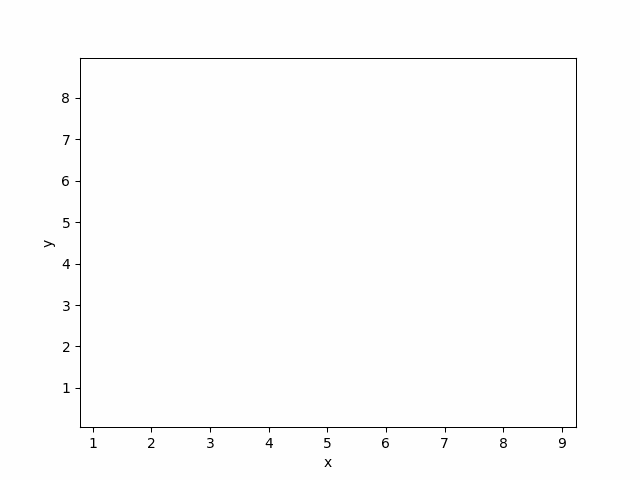

In [12]:
is_intersection_with_visualization(test).show_gif(interval=500)

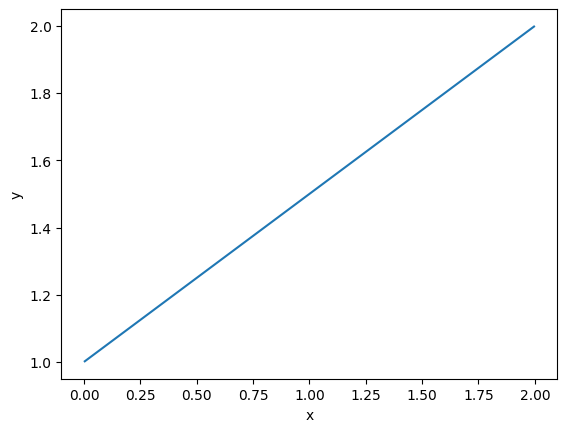

In [13]:
vis = Visualizer()
vis.add_line_segment(((0, 1), (2, 2)))
vis.show()

Uzupełnij funkcję ```find_intersections```

In [218]:
class Sweeper:
    #Inicjalizacja argumentów
    def __init__(self):
        self.intersecting_lines = []
        self.sorted_lines = SortedSet()
        self.intersections = set()
        self.events = SortedSet(key=lambda point: -point.x)
        self.lines = {} # Słownik typu (punkt -> prosta)
        self.s_lines = []

    #Funkcja główna
    def sweep(self, input_lines):
        self.s_lines = input_lines
        input_lines = convert_to_point_lines(input_lines)
        for line in input_lines:
            self.events.add(line.point_1)
            self.lines[line.point_1] = line
            self.events.add(line.point_2)
            self.lines[line.point_2] = line

        # min_y = reduce(lambda actual, point: point if point.y < actual.y else actual, self.lines.keys()).y
        # max_y = reduce(lambda actual, point: point if point.y > actual.y else actual, self.lines.keys()).y

        active_lines = SortedSet(key=lambda line: line.get_y(self.events[0].x))
        active_lines.update(self.sorted_lines)
        self.sorted_lines = active_lines

        while len(self.events) > 0:
            event = self.events.pop()
            self.handle_event(event)

        res = [((p.x, p.y), p.line_1, p.line_2) for p in self.intersections]
        ls = []
        ress = []
        for p, l1, l2 in res:
            if (l1, l2) not in ls and (l2, l1) not in ls:
                ls.append((l1, l2))
                ress.append((p, self.s_lines.index(l1.to_tuple()) + 1, self.s_lines.index(l2.to_tuple()) + 1))
        return ress

    def handle_event(self, event):
        if event in self.lines:
            line = self.lines[event]
            active_lines = SortedSet(key=lambda line: line.get_y(event.x))
            active_lines.update(self.sorted_lines)
            self.sorted_lines = active_lines

            if event == line.point_1:
                add_line(line, self.sorted_lines, self.events, self.intersections)
            else:
                remove_line(line, self.sorted_lines, self.events, self.intersections)
        else:
            self.intersections.add(event)
            line_1 = event.line_1
            line_2 = event.line_2

            remove_line(line_1, self.sorted_lines, self.events, self.intersections)
            remove_line(line_2, self.sorted_lines, self.events, self.intersections)
            active_lines = SortedSet(key=lambda line: line.get_y(eps + event.x))
            active_lines.update(self.sorted_lines)
            self.sorted_lines = active_lines

            add_line(line_1, self.sorted_lines, self.events, self.intersections)
            add_line(line_2, self.sorted_lines, self.events, self.intersections)

In [219]:
def helper(lines):
    new_broom = Sweeper()
    return new_broom.sweep(lines)

In [189]:
Test().runtest(3, helper)

Lab 4, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.014s


Uzupełnij funkcję ```find_intersections_with_visualization```

In [16]:
def find_intersections_with_visualization(lines):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    endpoints = []
    vis = Visualizer()
    vis.add_line_segment(lines, color="black")
    ls = {}
    st = []
    end = []
    for line in lines:
        endpoints.append((line[0], 'start', line))
        endpoints.append((line[1], 'end', line))

    end = [i[0] for i in endpoints if i[1] == 'end']
    st = [i[0] for i in endpoints if i[1] == 'start']
    vis.add_point(st, color="green")
    vis.add_point(end, color = "purple")

    endpoints.sort()
    maxY = max(endpoints, key=lambda x:x[0][1])[0][1]
    minY = min(endpoints, key=lambda x:x[0][1])[0][1]
    broom = vis.add_line_segment((endpoints[0][0], endpoints[0][0]))

    active_lines = []

    intersections = set()

    def make_broom(point, broom):
        vis.remove_figure(broom)
        return vis.add_line_segment(((point[0], minY), (point[0], maxY)), color="orange")

    for point, event, line in endpoints:
        if event == 'start':
            active_lines.append(line)
            l = vis.add_line_segment(line, color = "blue")
            ls[line] = l

        else:
            active_lines.remove(line)
            vis.remove_figure(ls[line])
            continue

        for active_line in active_lines:
            if active_line[0][0] > line[0][0]: continue
            inter = find_intersection(line, active_line)
            if inter:
                intersections.add((inter, lines.index(line) ,lines.index(active_line)))
                broom = make_broom(inter, broom)
                vis.add_point(inter, color = "red")  


    return vis

In [236]:
class SweeperVis:
    #Inicjalizacja argumentów
    def __init__(self):
        self.intersecting_lines = []
        self.sorted_lines = SortedSet()
        self.intersections = set()
        self.events = SortedSet(key=lambda point: -point.x)
        self.lines = {} # Słownik typu (punkt -> prosta)
        self.s_lines = []
        self.vis = Visualizer()
        self.ls = {}

    #Funkcja główna
    def sweep(self, input_lines):

        self.s_lines = input_lines
        self.vis.add_line_segment(input_lines)

        input_lines = convert_to_point_lines(input_lines)
        st = []
        end = []
        for line in input_lines:
            self.events.add(line.point_1)
            self.lines[line.point_1] = line
            self.events.add(line.point_2)
            self.lines[line.point_2] = line
            st.append(line.point_1.to_tuple())
            end.append(line.point_2.to_tuple())

        maxY = max(self.events, key=lambda x:x.y).y
        minY = min(self.events, key=lambda x:x.y).y
        minX = min(self.events, key=lambda x:x.x).x
        self.vis.add_point(st, color="green")
        self.vis.add_point(end, color = "purple")
        broom = self.vis.add_line_segment(((minX, minY), (minX, maxY)), color="orange")

        def make_broom(self, point, broom):
            self.vis.remove_figure(broom)
            return self.vis.add_line_segment(((point.x, minY), (point.x, maxY)), color="orange")

        active_lines = SortedSet(key=lambda line: line.get_y(self.events[0].x))
        active_lines.update(self.sorted_lines)
        self.sorted_lines = active_lines

        while len(self.events) > 0:
            event = self.events.pop()
            self.handle_event(event)
        
        return self.vis

    def handle_event(self, event):
        if event in self.lines:
            line = self.lines[event]
            active_lines = SortedSet(key=lambda line: line.get_y(event.x))
            active_lines.update(self.sorted_lines)
            self.sorted_lines = active_lines

            if event == line.point_1:
                add_line(line, self.sorted_lines, self.events, self.intersections)
            else:
                remove_line(line, self.sorted_lines, self.events, self.intersections)
        else:
            self.intersections.add(event)
            line_1 = event.line_1
            line_2 = event.line_2

            remove_line(line_1, self.sorted_lines, self.events, self.intersections)
            remove_line(line_2, self.sorted_lines, self.events, self.intersections)
            active_lines = SortedSet(key=lambda line: line.get_y(eps + event.x))
            active_lines.update(self.sorted_lines)
            self.sorted_lines = active_lines

            add_line(line_1, self.sorted_lines, self.events, self.intersections)
            add_line(line_2, self.sorted_lines, self.events, self.intersections)

    def add_lines_to_vis(self, lines):
        q = [i.to_tuple for i in lines]
        return self.vis.add_line_segment(q)
    
    def add_point_to_vis(self, points):
        q = [i.to_tuple for i in points]
        return self.vis.add_point(q)

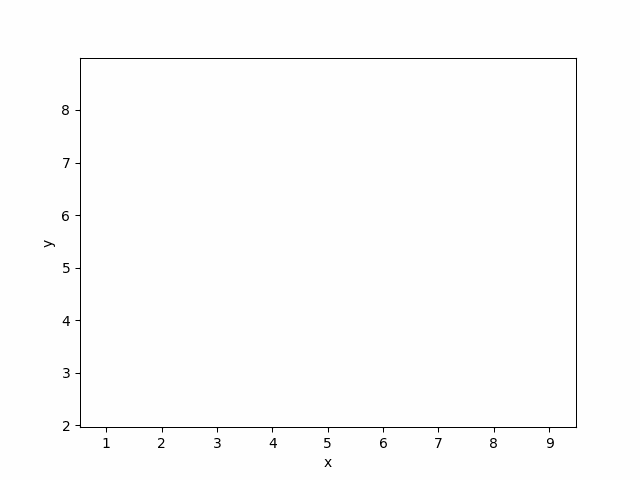

In [237]:
new_broom = SweeperVis()
ps = new_broom.sweep(test_examples[2])
ps.show_gif()

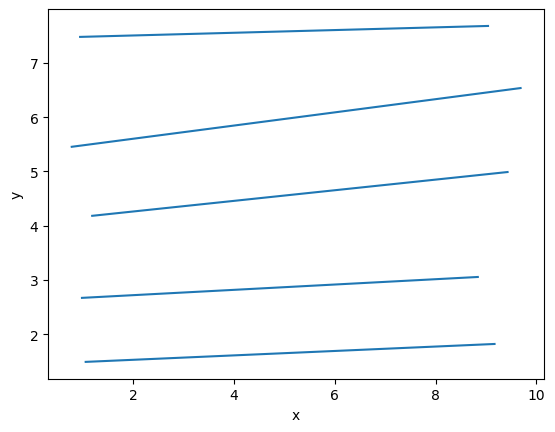

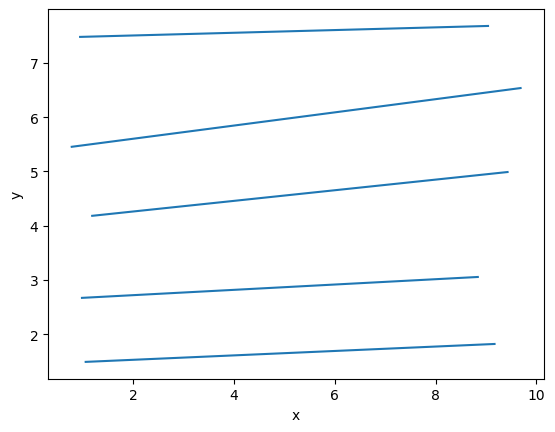

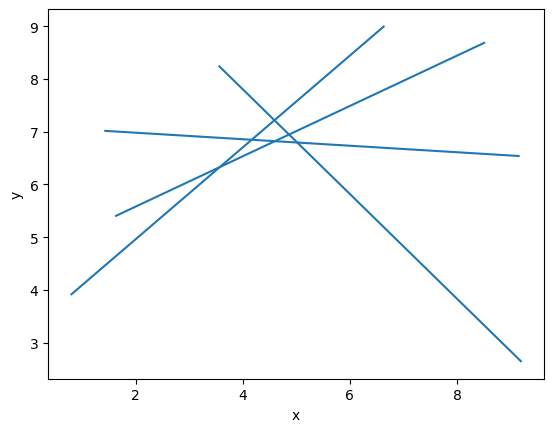

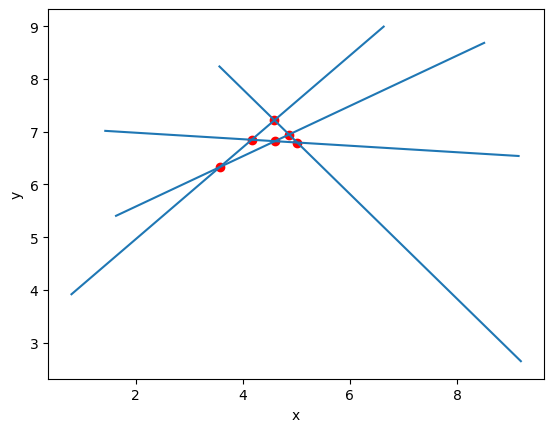

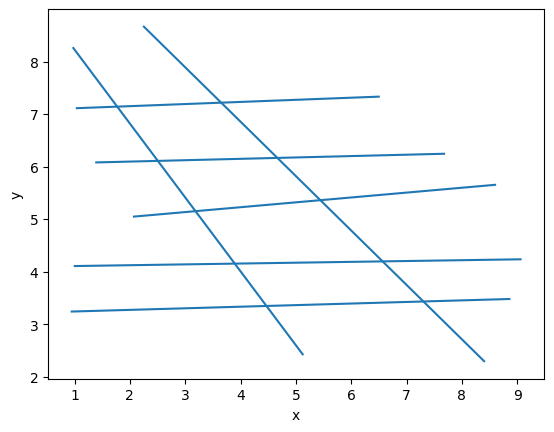

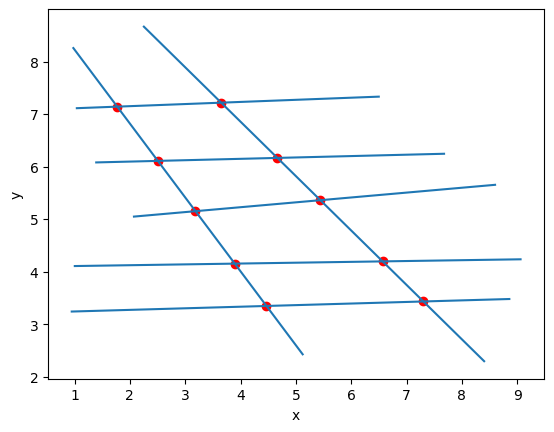

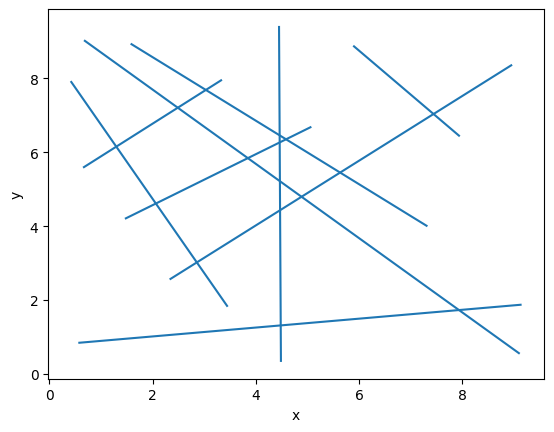

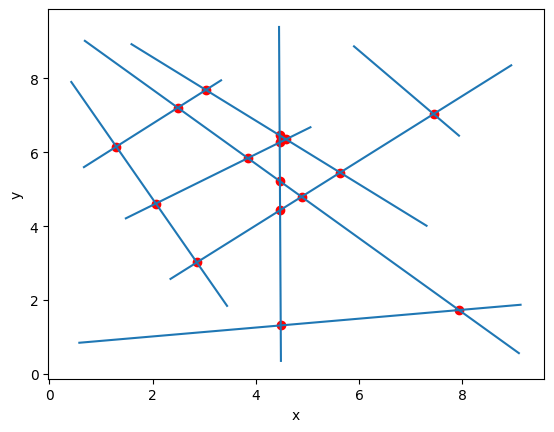

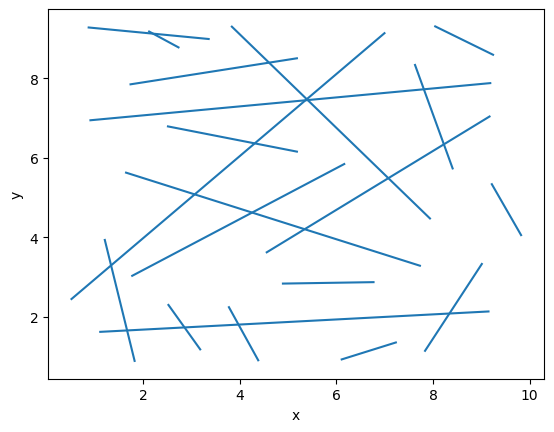

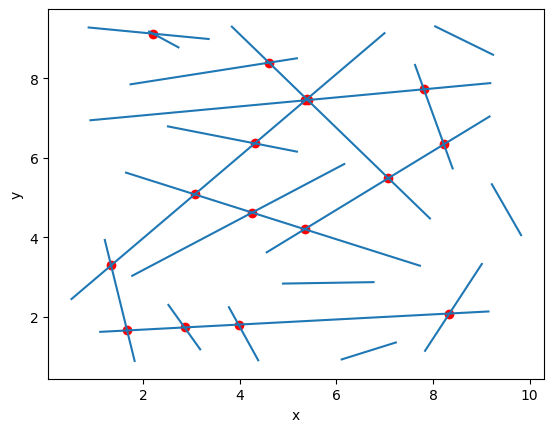

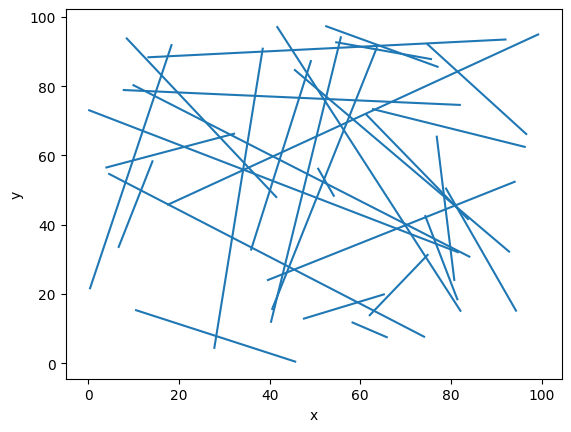

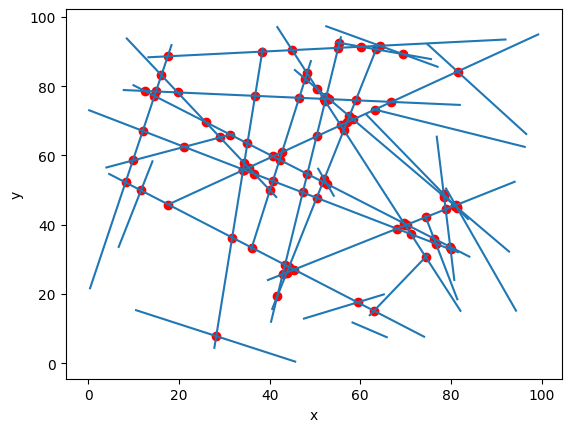

In [231]:
path = "../../sprawozdania/lab4/img/"
name = [(path + str(i), path + str(i) + "_int") for i in range(len(test_examples))]
for i in range(len(test_examples)):
    # draw_save_segments(test_examples[i], name[i][0])
    # draw_save_intersecitons(test_examples[i], find_intersections(test_examples[i]), name[i][1])
    draw_segments(test_examples[i])
    draw_intersecitons(test_examples[i], helper(test_examples[i]))

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.